# Mosaic from a single multitemporal dataset


The goal of this notebook is to provide an example of how to create a cloud-free mosaic from Sentinel-2 imagery over a specific area over a time period. We first use `satsearch` to search for Sentinel-2 data then get the `href` information to download data to a local machine. Images/Tiles will be then opened as a xarray DataArray. There can be many overlapping scenes so it is neccesary to coregister all images to have the same CRS and resolution (reprojection and resampling). A median operation will be applied to merge the images into a single layer that could be save off into Azure blob storage as COGs for later use.


## 1. Sentinel-2 Dataset

Satellite images (also Earth observation imagery, spaceborne photography, or simply satellite photo) are images of Earth collected by imaging satellites operated by governments and businesses around the world (see https://en.wikipedia.org/wiki/Satellite_imagery). Its major applications include Earth observation and land cover monitoring. 


SENTINEL-2 (https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/overview) is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas.

## 2. Environment setup

Necessary library are listed as below

In [1]:
import numpy as np
import xarray as xr
import datashader as ds
import pandas as pd
from datashader.transfer_functions import shade, Images
from datashader.colors import Elevation

from satsearch import Search

import xrspatial.multispectral as ms

## 3. Load the Sentinel 2 data

#### Define study area and search for data using `satsearch`

In this example, we use data from `sentinel-s2-l2a-cogs` collection within a bounding box of `[-93.112301, 29.649001, -92.075965, 30.719868]`, and the time range considered is from `2020-01-01` to `2020-12-31`.

In [2]:
items = Search(
    url="https://earth-search.aws.element84.com/v0",
    bbox=[-93.112301, 29.649001, -92.075965, 30.719868],
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-01-01/2020-01-31"
).items()

# print first item
print(items[0])
print(items[0].assets.keys())
print(items[0].assets['B02']['href'])

S2B_15RVN_20200131_0_L2A
dict_keys(['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL'])
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/15/R/VN/2020/1/S2B_15RVN_20200131_0_L2A/B02.tif


From the list of items found, choose 2 consecutive tiles of `15RVQ` and `15RWQ` on dates:  `'20200518', '20200617', '20200717', '20200816', '20200915', '20201015', '20201104', '20201224'`. Download corresponding data using the link in `item.assets[band_id]['href']` where `band_id` is one of following value: `['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL']`

This notebook only consider 3 bands: red (B04), green (B03), and blue (B02).


In [3]:
tiles = ['15RWQ']

dates =[
  '20200119',
  '20200228',
  '20200418',
  '20200518',
  '20200617',
  '20200717',
  '20200915',
  '20201015',
  '20201104',
  '20201224',
]

dates_mapping = {v: i for i, v in enumerate(dates)}

bands = ['B02', 'B03', 'B04']
bands_mapping = {v: i for i, v in enumerate(bands)}

In [4]:
path_dict = {}

for date in dates:
    path_dict[date] = {}
    for tile in tiles:
        path_dict[date][tile] = {}
        for band in bands:
            path_dict[date][tile][band] = f'E:\\S2A_{tile}_{date}_0_L2A\\{band}.tif'

In [5]:
def read_raw_data(path_dict=path_dict, dates=dates, tiles=tiles, bands=bands):    
    
    data_dict = {}
    
    for date in dates:
        data_dict[date] = {}
        
        for tile_id in tiles:            
            data_dict[date][tile_id] = {}
            for band in bands:
                # get the data path                        
                file_path = path_dict[date][tile_id][band]
                agg = xr.open_rasterio(file_path).astype(np.float)
                # correct value of band dim
                band_id = bands_mapping[band]
                agg['band'] = [band_id]
                data_dict[date][tile_id][band] = agg
    
    return data_dict

Raw data is stored in a nested python dictionary as below where they are organized by date, and tile, and band.

```
data_dict = {
    date_id: {
        tile_id: {
            band_id: 3D data array of (band, y, x)
        }
    }
}
```

Let's read raw data from files

In [6]:
# take some time to run
data_dict = read_raw_data()
data_dict

<ipython-input-5-bd40506a50df>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  agg = xr.open_rasterio(file_path).astype(np.float)


{'20200119': {'15RWQ': {'B02': <xarray.DataArray (band: 1, y: 10980, x: 10980)>
   array([[[415., 381., 375., ..., 101., 132.,  71.],
           [415., 393., 393., ..., 111., 157., 198.],
           [417., 417., 415., ..., 278., 266., 293.],
           ...,
           [100.,  84.,  68., ...,   0.,   0.,   0.],
           [ 71.,  95.,  94., ...,   0.,   0.,   0.],
           [ 98., 103.,  98., ...,   0.,   0.,   0.]]])
   Coordinates:
     * band     (band) int32 0
     * y        (y) float64 3.5e+06 3.5e+06 3.5e+06 ... 3.39e+06 3.39e+06 3.39e+06
     * x        (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05 6.098e+05
   Attributes:
       transform:           (10.0, 0.0, 499980.0, 0.0, -10.0, 3500040.0)
       crs:                 +init=epsg:32615
       res:                 (10.0, 10.0)
       is_tiled:            1
       nodatavals:          (0.0,)
       scales:              (1.0,)
       offsets:             (0.0,)
       AREA_OR_POINT:       Area
       OVR_RESAMPLING_ALG:

## 4. Preprocessing

For the same scence multitemporal data study, especially over a time series, there could be a slight shift among some images and pixels may be not perfectly aligned. 2 band images of a same tile and taken on the same day can have different sizes as well as different coords. Thus images need preprocessed through a co-registration approach.

An image is first read as a 3D (band, y, x) xarray DataArray. It will then be resampled to have the same shape (upsample or downsample) with datashader.Canvas.raster. After that images are coregistered to be well aligned.

####  Utilities functions

In [7]:
def resample(input_agg, sample_height=1000, sample_width=1000):
    # default resampling by datashader: mean with downsample and linear interpolation with upsample
    
    # define a canvas for resampling
    canvas = ds.Canvas(plot_height=sample_height, plot_width=sample_width)
    # resample
    resampled_agg = canvas.raster(input_agg.astype(np.float), nan_value=np.nan)    
    
    # attributes of resampled raster remain the same as of input raster
    resampled_agg.attrs = input_agg.attrs

    return resampled_agg


def resample_data(data_dict, dates=dates, tiles=tiles, bands=bands):
    resampled_data_dict = {}
    
    for date in dates:
        resampled_data_dict[date] = {}
        
        for tile in tiles:      
            resampled_data_dict[date][tile] = {}
            
            for band in bands:
                agg = data_dict[date][tile][band]
                resampled_data_dict[date][tile][band] = resample(agg)
    
    return resampled_data_dict


def get_coords_basis(data_dict, dates=dates, tiles=tiles, bands=bands):
    # choose coords of tiles in first date and first band as a basis for all sub-images
    date = dates[0]
    band = bands[0]
    coords_basis = {'x': {}, 'y': {}}
    
    for tile in tiles:
        coords_basis['x'][tile] = data_dict[date][tile][band].x
        coords_basis['y'][tile] = data_dict[date][tile][band].y
    
    return coords_basis
    
    
def coregister(data_dict, dates=dates, tiles=tiles, bands=bands):
    coords_basis = get_coords_basis(data_dict, dates, tiles, bands)
    
    for date in dates:
        for tile in tiles:
            for band in bands:
                data_dict[date][tile][band].coords['x'] = coords_basis['x'][tile]    
                data_dict[date][tile][band].coords['y'] = coords_basis['y'][tile]    

    return


def combine_bands(data_dict, dates=dates, tiles=tiles, bands=bands):
    
    for date in dates:
        for tile in tiles:
            # concatnate into a 3D cube
            band_aggs = [data_dict[date][tile][band] for band in bands]
            for band in bands:
                data_dict[date][tile] = xr.concat(band_aggs, dim='band')
    return
        
    
def combine_tiles_by_date(tile_grid):    
    combined_agg = xr.combine_nested(
        tile_grid,
        concat_dim=['y', 'x']
    ).chunk({'band': 1, 'y': 500, 'x': 500})
    
    return combined_agg

Preprocess data. For each tile of each day:
- resample to have the same shape
- coregister to have matching coords
- combine by bands to have a 3D data array with dimensions of `(band, y, x)`

Preprocessed data is stored in a nested python dictionary by date, and tile. Each element is a 3D cube of (band, y, x)
```
data_dict = {
    date_id: {
        tile_id: band-combined 3D data array
    }
}
```

In [8]:
resampled_data_dict = resample_data(data_dict)

# coregister if using more than 1 tile
# coregister(resampled_data_dict)

combine_bands(resampled_data_dict)

<ipython-input-7-b1df77e26b27>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  resampled_agg = canvas.raster(input_agg.astype(np.float), nan_value=np.nan)
<ipython-input-7-b1df77e26b27>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  resampled_agg = canvas.raster(input_agg.astype(np.float), nan_value=np.nan)


## Combine tiles into one DataArray

In this step, tiles are combined together by date and by band in order to form a full scence of the study area. We have many sub-images with overlapping xcoords and ycoords. In order to combine them in both 2 dimensions, we can use function combine_nested from xarray (http://xarray.pydata.org/en/stable/generated/xarray.combine_nested.html). This requires the datasets to be in the order that we wish them to be concatenated.

Here we just have 1 tile, so the grid is defined as 
```   
   [['15RWQ']]
    
```
Note that here we combine by both `y` and `x` so the grid is a 2D array.

We can then combine the combined aggregates as a 4D cube data array with the dimensions of `(time, band, y, x)`

In [9]:
date_aggs = []

for date in dates:
    grid_by_date = [ 
        [ resampled_data_dict[date]['15RWQ'] ] 
    ]
    agg = combine_tiles_by_date(grid_by_date)
    date_aggs.append(agg)
    
full_scene = xr.concat(date_aggs, dim='time')
full_scene['time'] = dates
full_scene

C:\Users\mdo\Anaconda3\envs\stac-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray (time: 10, band: 3, y: 1000, x: 1000)>
dask.array<concatenate, shape=(10, 3, 1000, 1000), dtype=float64, chunksize=(1, 1, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 5e+05 5.001e+05 5.003e+05 ... 6.096e+05 6.097e+05
  * y        (y) float64 3.5e+06 3.5e+06 3.5e+06 ... 3.391e+06 3.39e+06 3.39e+06
  * band     (band) int64 0 1 2
  * time     (time) <U8 '20200119' '20200228' ... '20201104' '20201224'

## 5. Mosaic scene

In this step, we use median operation to merge all images into 1 single cloud-free layer. As a matter of fact, cloud would not persist at specific positions time to time. 

In [10]:
median_scene = full_scene.median(dim=['time'])

### True Color

C:\Users\mdo\Anaconda3\envs\stac-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


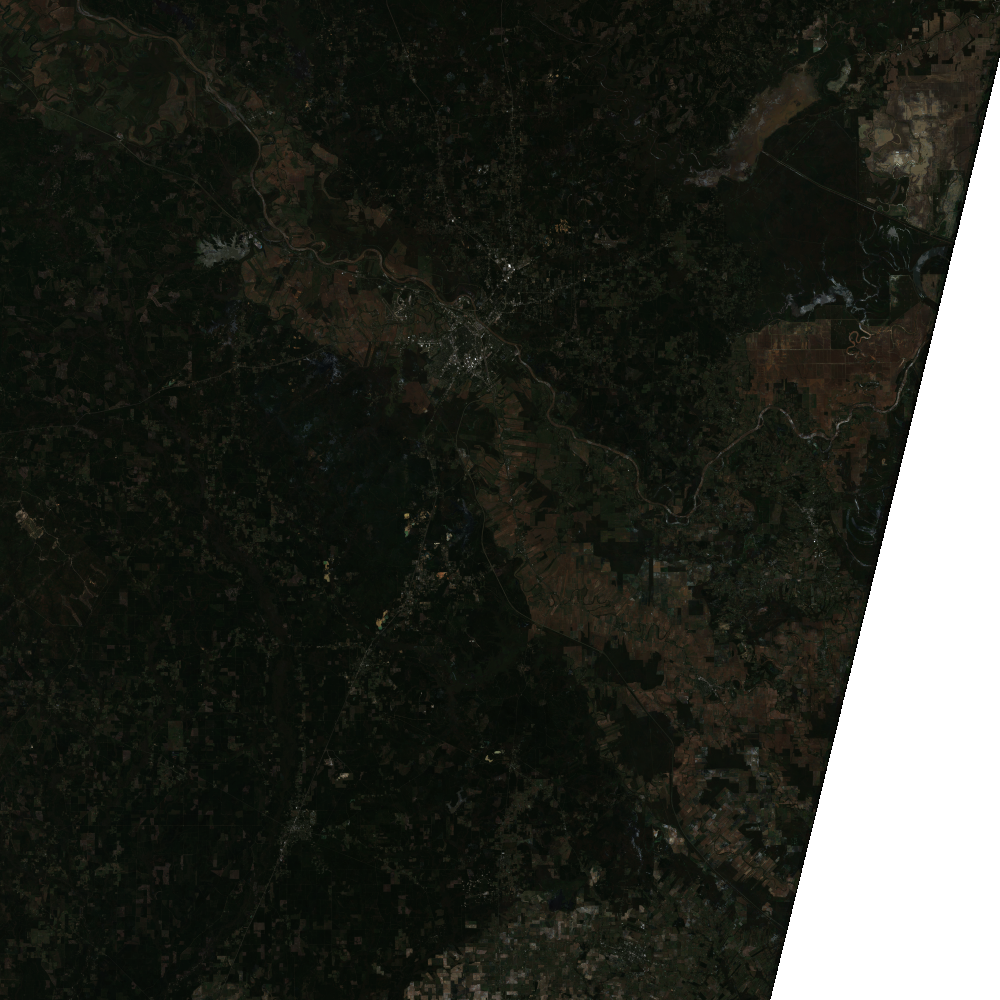

In [11]:
# True color
band_blue = bands_mapping['B02']
band_green = bands_mapping['B03']
band_red = bands_mapping['B04']

blue_agg = median_scene[band_blue].compute()
green_agg = median_scene[band_green].compute()
red_agg = median_scene[band_red].compute()

img = ms.true_color(red_agg, green_agg, blue_agg)
img

## 6. Save to Azure blob storage as COGs